# Museums in the Pandemic - Social media analytics

**Authors**: Andrea Ballatore (KCL)

**Abstract**: Analysis of social media data

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [11]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
import spacy
import re
from termcolor import colored
import matplotlib.dates as mdates
import sys
import numpy as np
import calplot
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db, get_indicator_annotations
from museums import get_museums_w_web_urls, get_twitter_facebook_links

cur_folder = out_folder + 'data/analysis/'

print('env ok')

Conda env: mip_v1


ModuleNotFoundError: No module named 'calplot'

## Connect to DB

It needs the DCS VPN active to work.

In [2]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


## Load museum info


In [3]:
def get_extra_attributes(df):
    df['governance_simpl'] = df['governance'].str.split(':').str[0].str.lower()
    df['subject_matter_simpl'] = df['subject_matter'].str.split(':').str[0]
    df['country'] = df['admin_area'].str.split('/').str[1]
    df['region'] = df['admin_area'].str.split('/').str[2]
    df['region'] = np.where(df['country'] == 'England', df['region'], df['country'])
    df['region'] = df['region'].str.replace('\(English Region\)','')
    print(df['governance_simpl'].value_counts())
    print(df['country'].value_counts())
    print(df['region'].value_counts())
    print(df['subject_matter_simpl'].value_counts())
    return df

# load museums
df = get_museums_w_web_urls(out_folder)
print("museums url N:",len(df))
attr_df = load_input_museums_wattributes(out_folder)
df = pd.merge(df, attr_df, on='muse_id', how='left')
print("museum df with attributes: len", len(df))
mus_df = df.rename(columns={'muse_id':'museum_id','musname_x':'musname'})
del df
print(len(mus_df), mus_df.columns)

links_df = get_twitter_facebook_links(out_folder)[['museum_id', 'twitter_id', 'facebook_pages']]
mus_df = mus_df.merge(links_df, on='museum_id', how='left')
mus_df = get_extra_attributes(mus_df)
del links_df
#print(len(mus_df), mus_df.columns)
mus_df.sample(50)

museums urls: ../../data/museums/museum_websites_urls-v3.tsv
nationaltrust.org.uk       179
english-heritage.org.uk     52
no_resource.                33
visitscotland.com           24
nts.org.uk                  21
                          ... 
glynnvivian.co.uk            1
glynde.co.uk                 1
gwsr.com                     1
gloucesterquays.co.uk        1
smithsonfarm.co.uk           1
Name: domain, Length: 2441, dtype: int64
get_museums_w_web_urls Museums=3344 URLs=3344
museums url N: 3344
Index(['musname', 'muse_id', 'town', 'postcode', 'accreditation', 'governance',
       'size', 'subject_matter', 'closing_date', 'provenance',
       'deprivation_index', 'geodemographic_group', 'geodemographic_subgroup',
       'admin_area'],
      dtype='object')
loaded museums w attributes (open): 3341 data/museums/museums_wattributes-2020-02-23.tsv
museum df with attributes: len 3344
3344 Index(['museum_id', 'musname', 'town_x', 'url', 'url_source', 'Unnamed: 5',
       'domain', 'm

/var/folders/f6/jwz5v525215521t6qbnxcdh80000gn/T/ipykernel_17804/3366711016.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['region'] = df['region'].str.replace('\(English Region\)','')


,museum_id,musname,town_x,url,url_source,Unnamed: 5,domain,musname_y,town_y,postcode,...,deprivation_index,geodemographic_group,geodemographic_subgroup,admin_area,twitter_id,facebook_pages,governance_simpl,subject_matter_simpl,country,region
541,mm.ace.1092,Charlecote Park,Warwick,https://www.nationaltrust.org.uk/charlecote-park,pred,NaN,nationaltrust.org.uk,Charlecote Park,Warwick,CV35 9ER,...,8.0,English and Welsh Countryside,Older Farming Communities,/England/West Midlands (English Region)/Warwic...,twitter.com/charlecotent,"['www.facebook.com/charlecotent', 'en-gb.faceb...",independent,Buildings,England,West Midlands
784,mm.domus.SE015,Design Museum,London,https://designmuseum.org/,pred,NaN,designmuseum.org,Design Museum,London,W8 6AG,...,7.0,London Cosmopolitan,London Cosmopolitan,/England/London (English Region)/Kensington an...,twitter.com/designmuseum,"['facebook.com/designmuseum', 'en-gb.facebook....",independent,Arts,England,London
941,mm.domus.SW044,Exmouth Museum,Exmouth,https://www.exmouthmuseum.co.uk/,pred,NaN,exmouthmuseum.co.uk,Exmouth Museum,Exmouth,EX8 1PW,...,4.0,Remoter Coastal Living,Ageing Coastal Living,/England/South West (English Region)/Devon (En...,twitter.com/exmouthm,['www.facebook.com/sheppardsrow'],independent,Local Histories,England,South West
348,mm.ace.1235,Brading Roman Villa,Brading,https://bradingromanvilla.org.uk/,manual,NaN,bradingromanvilla.org.uk,Brading Roman Villa,Brading,PO36 0EN,...,4.0,Remoter Coastal Living,Ageing Coastal Living,/England/South East (English Region)/Isle of W...,twitter.com/bradingvilla,en-gb.facebook.com/TheBradingRomanVilla,independent,Archaeology,England,South East
2115,mm.domus.SW182,Pendennis Castle,Falmouth,https://www.english-heritage.org.uk/visit/plac...,pred,NaN,english-heritage.org.uk,Pendennis Castle,Falmouth,TR11 4LP,...,6.0,Remoter Coastal Living,Ageing Coastal Living,/England/South West (English Region)/Cornwall ...,no_resource,"['www.facebook.com/pendenniscastle', 'en-gb.fa...",independent,War and conflict,England,South West
2656,mm.domus.SC196,Summerlee Museum Of Scottish Industrial Life,Coatbridge,https://culturenl.co.uk/museums/visiting-us/su...,pred,NaN,culturenl.co.uk,Summerlee Museum Of Scottish Industrial Life,Coatbridge,ML5 1QD,...,5.0,Scottish Industrial Heritage,Scottish Industrial Legacy,/Scotland/North Lanarkshire (Scottish Council ...,twitter.com/summerleemuseum,"['www.facebook.com/summerleemuseum', 'www.face...",government,Industry and manufacture,Scotland,Scotland
830,mm.domus.NI019,Downpatrick & County Down Railway,Downpatrick,https://www.downrail.co.uk/,pred,NaN,downrail.co.uk,Downpatrick & County Down Railway,Downpatrick,BT30 6LZ,...,2.0,Northern Ireland Countryside,Northern Ireland Countryside,/Northern Ireland/Newry (NI Loc Gov District),twitter.com/downrail,['www.facebook.com/downrail'],independent,Transport,Northern Ireland,Northern Ireland
1328,mm.domus.SE455,Ifield Watermill,Crawley,https://crawleymuseums.org/ifield-watermill/,pred,NaN,crawleymuseums.org,Ifield Watermill,Crawley,RH11 0PL,...,5.0,Suburban Traits,Expanding Areas,/England/South East (English Region)/West Suss...,['twitter.com/crawleymuseum'],['en-gb.facebook.com/crawleymuseum'],government,Rural Industry,England,South East
25,mm.domus.SC002,Aberdeen Art Gallery,Aberdeen,http://www.aagm.co.uk/,pred,NaN,aagm.co.uk,Aberdeen Art Gallery,Aberdeen,AB10 1FQ,...,5.0,Larger Towns and Cities,Larger Towns and Cities,/Scotland/Aberdeen City (Scottish Council Area),twitter.com/abdnartmuseums,en-gb.facebook.com/AbdnArtMuseums,government,Arts,Scotland,Scotland
2634,mm.hha.184,Stradey Castle,Llanelli,https://www.stradeycastle.com/,pred,NaN,stradeycastle.com,Stradey Castle,Llanelli,SA15 4PL,...,5.0,English and Welsh Countryside,Sparse English and Welsh Countryside,/Wales/Carmarthenshire (Welsh UA),twitter.com/stradeycastle,"['www.facebook.com/stradeycastle', 'en-gb.face...",independent,Buildings,Wales,Wales


## Temporal analysis of Twitter/Facebook

Temporal analysis based on message counts.

In [4]:
# file paths
tw_fn = out_folder+'tmp/tweets.pik'
fb_fn = out_folder+'tmp/facebook_posts.pik'

### Download Twitter/Facebook data from DB (slow)

In [5]:
if False:
    sql = "select muse_id as museum_id, account, tw_ts as ts from twitter.tweets_dump td;" # limit 10000
    df = pd.read_sql(sql, db_conn)
    df['ts'] = pd.to_datetime(df['ts'])
    print(df.columns)
    df = df.set_index('ts')
    df.to_pickle(tw_fn)
    print(len(df))
    tw_fn

    sql = "select museum_id, post_ts as ts from facebook.facebook_posts_dump;" # limit 10000
    df = pd.read_sql(sql, db_conn)
    df['post_ts'] = pd.to_datetime(df['post_ts'])
    print(df.columns)
    df = df.set_index('post_ts')
    df.to_pickle(fb_fn)
    print(len(df))
    fb_fn

### Activity by museum

In [6]:
def messages_by_museum(df, label):
    print('messages_by_museum', label, len(df))
    mdf = df.groupby('museum_id').size()
    field = 'msg_count_'+label
    mdf = mdf.reset_index(name=field)
    mdf[field+'_decile'] = pd.qcut(-mdf[field], 10, labels=False)+1
    mdf[field+'_z'] = round((mdf[field] - mdf[field].mean())/mdf[field].std(),3)
    print(mdf.columns)
    return mdf
    
# generate tweet plots
df = pd.read_pickle(tw_fn)
act_df = messages_by_museum(df, 'twitter')

df = pd.read_pickle(fb_fn)
act_df2 = messages_by_museum(df, 'facebook')
act_df = act_df.merge(act_df2, on='museum_id', how='outer')

# merge with all museums
act_df = act_df.merge(mus_df, on='museum_id', how='outer')
act_df['msg_count_facebook'] = act_df['msg_count_facebook'].fillna(0)
act_df['msg_count_twitter'] = act_df['msg_count_twitter'].fillna(0)

fout = cur_folder + 'temporal_analysis/msg_count_by_museum.xlsx'
act_df.to_excel(fout, index=False)
fout

messages_by_museum twitter 5653012
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z'],
      dtype='object')
messages_by_museum facebook 1468515
Index(['museum_id', 'msg_count_facebook', 'msg_count_facebook_decile',
       'msg_count_facebook_z'],
      dtype='object')


'../../data/analysis/temporal_analysis/msg_count_by_museum.xlsx'

#### Total stats

In [7]:
# activity stats
for plat in ['twitter','facebook']:
    df = act_df.copy()
    df['msg_count_'+plat] = df['msg_count_'+plat] + 1
    ax = sns.histplot(data=df, x="msg_count_"+plat, kde=True, log_scale=True)
    ax.set_title('Museums on '+plat)
    ax.set_xlabel('Number of messages (total)')
    ax.set_ylabel('N of museums')
    fout = cur_folder+'/temporal_analysis/museum_activity_hist_{}.pdf'.format(plat)
    plt.savefig(fout)
    plt.clf()
    print(fout)
    del df

../../data/analysis//temporal_analysis/museum_activity_hist_twitter.pdf
../../data/analysis//temporal_analysis/museum_activity_hist_facebook.pdf


<Figure size 432x288 with 0 Axes>

#### Generate group stats


activity_stats_mus_groups ['governance']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


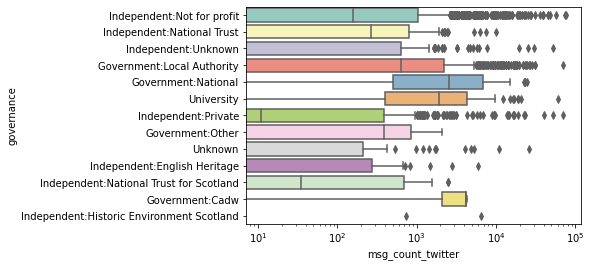


activity_stats_mus_groups ['governance_simpl']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


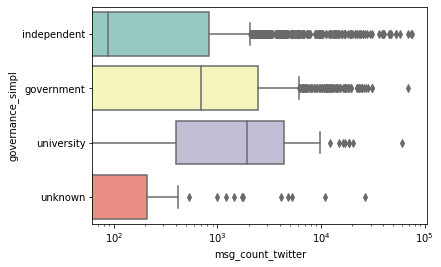


activity_stats_mus_groups ['size']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


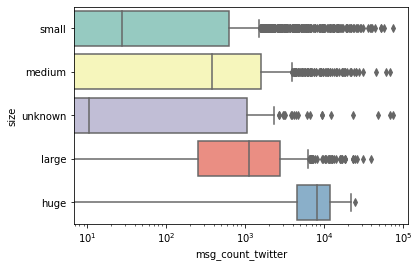


activity_stats_mus_groups ['subject_matter']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


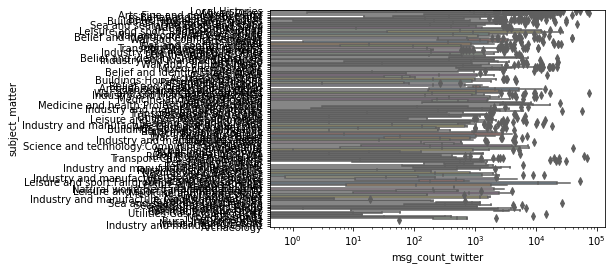


activity_stats_mus_groups ['accreditation']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


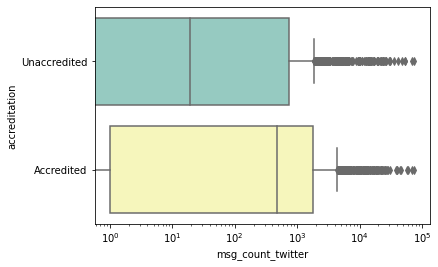


activity_stats_mus_groups ['region']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


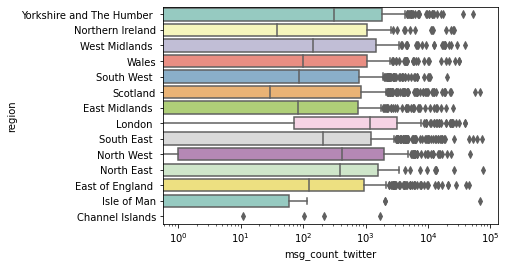


activity_stats_mus_groups ['country']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


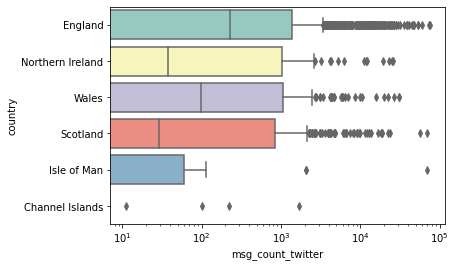


activity_stats_mus_groups ['subject_matter_simpl']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


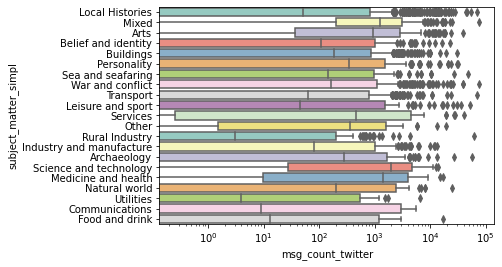


activity_stats_mus_groups ['size', 'governance']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


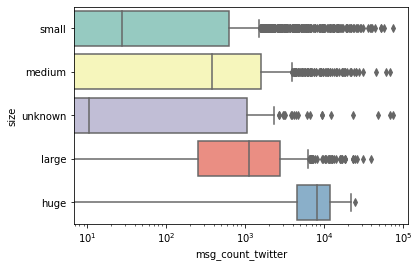

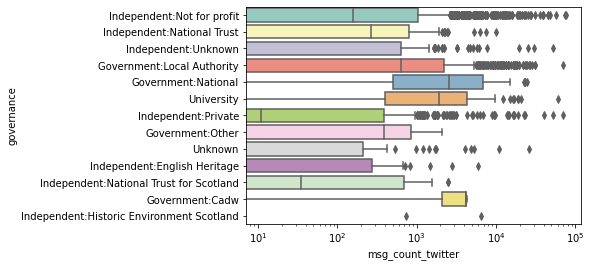


activity_stats_mus_groups ['country', 'governance_simpl']
Index(['museum_id', 'msg_count_twitter', 'msg_count_twitter_decile',
       'msg_count_twitter_z', 'msg_count_facebook',
       'msg_count_facebook_decile', 'msg_count_facebook_z', 'musname',
       'town_x', 'url', 'url_source', 'Unnamed: 5', 'domain', 'musname_y',
       'town_y', 'postcode', 'accreditation', 'governance', 'size',
       'subject_matter', 'closing_date', 'provenance', 'deprivation_index',
       'geodemographic_group', 'geodemographic_subgroup', 'admin_area',
       'twitter_id', 'facebook_pages', 'governance_simpl',
       'subject_matter_simpl', 'country', 'region'],
      dtype='object')


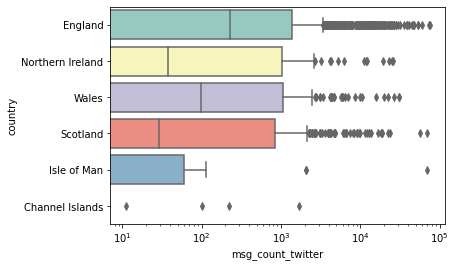

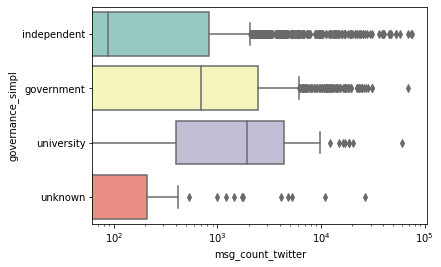

<Figure size 432x288 with 0 Axes>

In [8]:
# governance / size stats
# attr

var_combinations = [['governance'],['governance_simpl'],['size'],['subject_matter'],
        ['accreditation'],['region'],['country'],['subject_matter_simpl'],
        ['size','governance'],['country','governance_simpl']]

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def active_mus_n(x):
    #print(x.describe())
    return len(x[x>0])

def active_mus_pc(x):
    # dummy value
    return -1

def active_mus_pc_z(x):
    # dummy value
    return -1

def activity_stats_mus_groups(df, vars):
    print('\nactivity_stats_mus_groups', vars)
    print(df.columns)
    stats_cols = ['mean','std','min',q25,'median',q75,'max','count',active_mus_n,active_mus_pc,active_mus_pc_z]
    stats_df = df.groupby(vars).agg({
        'msg_count_twitter': stats_cols,
        'msg_count_facebook': stats_cols
    }).round(1)
    #print(stats_df.index)
    #print(stats_df.columns)
    # calculate derived fields
    for c in ['msg_count_twitter','msg_count_facebook']:
        stats_df[(c,'active_mus_pc')] = round(stats_df[(c,'active_mus_n')]/stats_df[(c,'count')]*100,1)
        x = stats_df[(c,'active_mus_pc')]
        stats_df[(c,'active_mus_pc_z')] = round((x - x.mean())/x.std(), 1)
    return stats_df

# generate all combinations
for attrs in var_combinations:
    # calc stats
    df = activity_stats_mus_groups(act_df, attrs)
    attrs_str = '_'.join(attrs)
    fout = cur_folder+'/temporal_analysis/museum_activity_groups_var{}_{}.xlsx'.format(len(attrs), attrs_str)
    df.to_excel(fout,index=True)
    
    # plot
    for att in attrs:
        ax = sns.boxplot(x="msg_count_twitter", y=att, # hue="governance",
                     data=act_df, palette="Set3")
        ax.set_xscale("log")
        plt.show()
        plt.clf()

### All tweets/posts over time

Summarise tweets using pandas aggregation.

In [9]:
def generate_time_plots(df, label, aggr_func):
    print('generate_time_plots', label)
    print('date range:', min(df.index), max(df.index))
    tdf = pd.DataFrame()
    for time_aggr in ['W','D','M','Q']:
        print(time_aggr)
        tmpdf = aggr_func(df, time_aggr)

        # plot tweets
        fig, ax = plt.subplots()
        tmpdf['count'].plot(linewidth=1, figsize=(20,7))
        plt.title('All museums - N={} - {} over time by {}'.format(len(df), label, time_aggr))
        plt.xlabel('Time')
        plt.grid(True, which='both')
        plt.ylabel('N  '+label)
        #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
        fig_fn = out_folder+'data/analysis/temporal_analysis/{}_temporal-all_mus-{}.pdf'.format(label,time_aggr)
        plt.savefig(fig_fn)
        print(fig_fn)
        #plt.show()
        
        plt.clf(); plt.cla(); plt.close()

        # add data
        tmpdf = tmpdf.reset_index()
        tdf.append(tmpdf)

    return tdf

def count_messages(df, time_aggr):
    tmpdf = df.resample(time_aggr).size().to_frame('count')
    tmpdf['time_unit'] = time_aggr
    return tmpdf

# generate tweet plots
df = pd.read_pickle(tw_fn)
print(len(df))
print(df.sample(10))
generate_time_plots(df, 'tweets', count_messages)

# generate facebook plots
df = pd.read_pickle(fb_fn)
print(len(df))
print(df.sample(10))
generate_time_plots(df, 'facebook_posts', count_messages)

5653012
                                museum_id          account
ts                                                        
2020-06-23 07:51:57+00:00  mm.domus.SC301  trimontiumtrust
2020-11-13 12:30:00+00:00     mm.musa.252      spacecentre
2021-08-11 14:19:20+00:00  mm.domus.NW165     lancsmuseums
2021-03-22 10:01:17+00:00  mm.domus.YH106          artfund
2019-05-07 01:11:23+00:00  mm.domus.SE410        metmuseum
2020-12-24 06:53:52+00:00      mm.mgs.345    eca_edinburgh
2020-07-09 10:08:30+00:00  mm.domus.SE377      kettlesyard
2021-01-11 15:46:13+00:00     mm.ace.1131     royalacademy
2021-06-04 12:00:11+00:00      mm.ace.042  haringeycouncil
2019-05-02 07:56:54+00:00   mm.aim82M.028      biker_nigel
generate_time_plots tweets
date range: 2019-01-01 00:00:00+00:00 2021-10-15 12:45:39+00:00
W
../../data/analysis/temporal_analysis/tweets_temporal-all_mus-W.pdf
D
../../data/analysis/temporal_analysis/tweets_temporal-all_mus-D.pdf
M
../../data/analysis/temporal_analysis/tweets_tempor

""


### Active museums over time

Count museums that are active on FB/TW in a give period

In [10]:
def count_museums(df, time_aggr):
    df = df[['museum_id']]
    tmpdf = df.resample(time_aggr).nunique()
    tmpdf.columns = ['count']
    tmpdf['time_unit'] = time_aggr
    return tmpdf

# generate tweet plots
df = pd.read_pickle(tw_fn)
print(len(df))
generate_time_plots(df, 'museums_on_tw', count_museums)

# generate facebook plots
df = pd.read_pickle(fb_fn)
print(len(df))
generate_time_plots(df, 'museums_on_fb', count_museums)

5653012
generate_time_plots museums_on_tw
date range: 2019-01-01 00:00:00+00:00 2021-10-15 12:45:39+00:00
W
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-W.pdf
D
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-D.pdf
M
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-M.pdf
Q
../../data/analysis/temporal_analysis/museums_on_tw_temporal-all_mus-Q.pdf
1468515
generate_time_plots museums_on_fb
date range: 2019-01-01 00:00:00+00:00 2021-10-20 23:43:03+00:00
W
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-W.pdf
D
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-D.pdf
M
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-M.pdf
Q
../../data/analysis/temporal_analysis/museums_on_fb_temporal-all_mus-Q.pdf


""


### Daily heatmaps

- Calplot package: https://www.analyticsvidhya.com/blog/2021/02/visualization-in-time-series-using-heatmaps-in-python/

In [14]:
!pip install calplot

In [48]:
import calplot

def plot_daily_heatmap(df, label):
    # count tweets per day
    cmap = None
    cdf = df[['museum_id']].resample('D').count()
    ax = calplot.calplot(cdf['museum_id'], cmap=cmap, suptitle='Total messages per day -'+label)
    fig_fn = out_folder+'data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_{}-msg.pdf'.format(label)
    plt.savefig(fig_fn)
    plt.clf()
    del cdf
    # count active museums per day
    mdf = df[['museum_id']].resample('D').nunique()
    ax = calplot.calplot(mdf['museum_id'], cmap=cmap, suptitle='Active museums per day -'+label)
    fig_fn = out_folder+'data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_{}-active_mus.pdf'.format(label)
    #plt.tight_layout()
    plt.savefig(fig_fn)
    print(fig_fn)
    plt.clf()
    del mdf

df = pd.read_pickle(tw_fn)
plot_daily_heatmap(df, 'twitter')

df = pd.read_pickle(fb_fn)
plot_daily_heatmap(df, 'facebook')

/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore

../../data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_twitter-active_mus.pdf


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/calplot/calplot.py:189: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/andreaballatore

../../data/analysis/temporal_analysis/daily_heatmap-all_mus_heatmap_facebook-active_mus.pdf


<Figure size 900x367.2 with 0 Axes>

<Figure size 900x367.2 with 0 Axes>

<Figure size 900x367.2 with 0 Axes>

<Figure size 900x367.2 with 0 Axes>

End of notebook.